# Debugging as to why `grid.diff()` is taking forever

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import json
import fsspec
import gcsfs
import xmitgcm
from xhistogram.xarray import histogram

In [4]:
#look to see what local dask is doing behind the scenes

from dask.distributed import LocalCluster, Client
import dask

with dask.config.set(**{"distributed.dashboard.link": "/user/{JUPYTERHUB_USER}/proxy/{port}/status"}):
    cluster = LocalCluster()
    client = Client(cluster)

2022-07-28 01:45:28,491 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/chapter2/CESM/dask-worker-space/worker-i7jtphs3', purging
2022-07-28 01:45:28,506 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/chapter2/CESM/dask-worker-space/worker-12ai9qsy', purging
2022-07-28 01:45:28,521 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/chapter2/CESM/dask-worker-space/worker-40i0jh87', purging
2022-07-28 01:45:28,535 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/chapter2/CESM/dask-worker-space/worker-33a2v0x1', purging


In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/shanicetbailey/proxy/8787/status,
Dashboard: /user/shanicetbailey/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 14.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42201,Workers: 4
Dashboard: /user/shanicetbailey/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 14.65 GiB
Comm: tcp://127.0.0.1:33903,Total threads: 1
Dashboard: /user/shanicetbailey/proxy/40959/status,Memory: 3.66 GiB
Nanny: tcp://127.0.0.1:45285,


In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds_unsliced  = cat["CESM_POP_hires_control"].to_dask()
ds = ds_unsliced.isel(time=slice(0,182))# slicing to just first 6mo (to match tendencies ds)

In [61]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds)#, periodic=['X'])

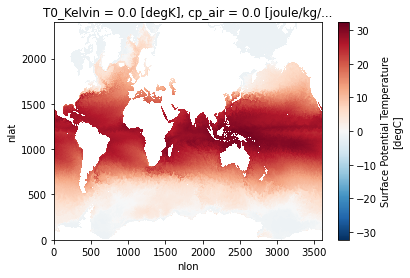

In [6]:
#testing just to see if local client's task stream is rendering
ds_unsliced.SST[0].plot()

In [8]:
#np.random.seed(0)
#temperature = 15 + 8 * np.random.randn(14965, 2400, 3600)
test_values = dsa.random.random((14965, 2400, 3600), chunks=(1, 2400, 3600))
time = pd.date_range('2000-01-01', '2040-12-20') #same shape as ds_ren.time
lat = np.linspace(-85,90,2400)
lon = np.linspace(0,3600, 3600)

In [3]:
#trying w/o dask array and smaller size
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds.isel(time=slice(0,40), nlat=slice(0,90), nlon=slice(0,180)))#, periodic=['X'])

np.random.seed(0)
temp = 15 + 8 * np.random.randn(40, 90, 180)
precip = 10 * np.random.rand(40,90,180)
time = pd.date_range('2000-01-01', '2000-02-9')
lat = np.linspace(-85,90,90)
lon = np.linspace(0,3600, 180)

In [11]:
da_test = xr.DataArray(data=test_values,
                       dims=['time', 'nlat_t', 'nlon_t'],
                       coords={'time':time, 'nlat_t':lat, 'nlon_t':lon},
                       name='test',
                       attrs=dict(description='test array to test grid.diff() speed'))

In [8]:
np.random.seed(0)
temperature = 15 + 8 * np.random.randn(2, 2, 3)
precipitation = 10 * np.random.rand(2, 2, 3)
lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]
time = pd.date_range("2014-09-06", periods=3)
reference_time = pd.Timestamp("2014-09-05")

ds = xr.Dataset(data_vars=dict(temperature=(["nlon", "nlat", "time"], temperature),
                               precipitation=(["nlon", "nlat", "time"], precipitation)),
                coords=dict(lon=(["nlon", "nlat"], lon),
                            lat=(["nlon", "nlat"], lat),
                            time=time,
                            reference_time=reference_time))
ds

<xarray.Dataset>
Dimensions:         (nlon: 2, nlat: 2, time: 3)
Coordinates:
    lon             (nlon, nlat) float64 -99.83 -99.32 -99.79 -99.23
    lat             (nlon, nlat) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: nlon, nlat
Data variables:
    temperature     (nlon, nlat, time) float64 29.11 18.2 22.83 ... 16.15 26.63
    precipitation   (nlon, nlat, time) float64 5.68 9.256 0.7104 ... 4.615 7.805

In [13]:
ds.temperature.coords

Coordinates:
    lon             (nlon, nlat) float64 -99.83 -99.32 -99.79 -99.23
    lat             (nlon, nlat) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05

In [14]:
ds.temperature.dims

('nlon', 'nlat', 'time')

In [9]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds)

In [11]:
%timeit grid.diff(ds_ren.temperature, 'X')

KeyError: "None of the DataArray's dims ('nlon', 'nlat', 'time') were found in axis coords."

In [12]:
#trying w/ randomized ds 
ds_test = da_test.to_dataset(name='test').rename_dims({'nlon_t':'nlon', 'nlat_t':'nlat'})
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds_test, periodic=False)

In [13]:
ds_ren_addcoords = ds_ren.test.expand_dims(dim={'nlat_t':ds_ren.nlat_t, 'nlon_t':ds_ren.nlon_t})

In [14]:
ds_ren_addcoords

<xarray.DataArray 'test' (nlat_t: 90, nlon_t: 180, time: 40, nlat: 90, nlon: 180)>
array([[[[[29.11241877, 18.20125767, 22.82990387, ...,  9.48360178,
           11.35573997, 15.13983327],
          [12.16804871,  4.00038965,  9.85105278, ..., 11.17620797,
           11.16275349, 19.96286639],
          [20.58765719, 15.03016711, 22.45478699, ..., 13.54204173,
           13.37682527, 14.12093777],
          ...,
          [31.48692484,  5.85832996,  9.62323532, ..., 16.41942987,
           23.8126442 ,  4.99673167],
          [30.96973607,  8.96101743, 11.40333513, ..., 22.77230351,
           16.99631488, 30.88838203],
          [17.90582743, 23.394778  ,  0.70923929, ..., 22.83726107,
            0.71902484, 11.57124031]],

         [[24.84340241, 23.15683918, 16.56535962, ...,  6.74642534,
           29.5609347 , 12.89327082],
          [18.97893147,  7.99099016,  8.84159986, ...,  7.76760702,
            1.58896698, 30.86227206],
          [18.31281691, 20.77358844, 17.67278865, ..., 12.02432202,
            5.131635  ,  4.3961609 ],
...
          [ 4.77766723, 20.68370314,  8.21811568, ..., 16.08903896,
            7.76135645, 14.42093673],
          [18.47278234,  5.82613004, 13.69146733, ...,  9.56930099,
           24.79060168, 28.76779373],
          [ 5.3200213 , 20.6388019 ,  6.20838144, ..., 11.07124527,
           19.95891363, 10.12482298]],

         [[24.10532089, 16.01613244, 16.99764718, ..., 17.17445581,
           22.70765905, 16.11943744],
          [27.59357369, 16.53341004, 12.36879654, ..., 30.86271612,
           11.13117282, 15.60346893],
          [14.20463044, 17.70841554, 19.38581481, ..., 29.08496835,
            8.23766989, 10.87318163],
          ...,
          [21.80008694,  6.26033655, 20.05413958, ..., 18.72005503,
           26.4735526 , 13.80189624],
          [22.06229878, -0.49227183, 22.13866924, ..., 14.19550687,
           10.97761511,  6.54369235],
          [16.37749664, 22.51298046, 10.1932547 , ...,  3.44028976,
           21.01952386, 23.56171499]]]]])
Coordinates:
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 85.5 86.5 87.5 88.5 89.5
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 176.5 177.5 178.5 179.5
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-02-09
Dimensions without coordinates: nlat, nlon
Attributes:
    description:  test array to test grid.diff() speed

In [ ]:
%timeit grid.diff(ds_ren_addcoords, 'X')

- changed `da_test.time` dtype from MS[n] to 'O'
- changed lon from int64 to float 64
- random dask array, numpy always shuts down
- changed array to just be xr datarray tried smaller array size with same dtypes for all coords as `ds_ren`
- tried changing `grid, ds_ren` line to put random ds in `pop_tools.xgcm_grid()`

**Result:** cell still takes forever to run 7/27/22